1. 时序模型中，当前数据跟之前观察到的数据相关
2. 自回归模型使用自身过去数据来预测未来
3. 马尔可夫模型假设当前只跟最近少数数据相关，从而简化模型
4. 潜变量模型使用潜变量来概括历史信息

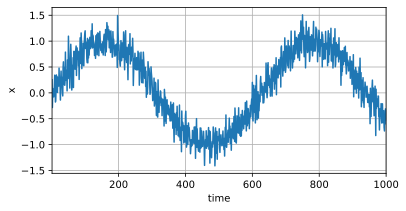

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))